# 4 Degree of Freedom Robot Arm

In [7]:
import time
import numpy as np
from sympy import *
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from IPython.display import display, Math

from tools import *

## Variables and settings

In [8]:
# Constants
l0 = symbols('l_0')
l2 = symbols('l_2')
l3 = symbols('l_3')
l4 = symbols('l_4')
le = symbols('l_e')
l0_val = 15
l2_val = 20
l3_val = 15
l4_val = 5
le_val = 10

# Variables
theta2 = symbols(r"\theta_2")
theta3 = symbols(r"\theta_3")
theta4 = symbols(r"\theta_4")
d1 = symbols('d_1')

alias = {}

# display cos(theta) as c\theta, sin(theta) as s\theta
alias.update({sin(theta2): symbols(r"s\theta_2"),
              cos(theta2): symbols(r"c\theta_2"),
              sin(theta3): symbols(r"s\theta_3"),
              cos(theta3): symbols(r"c\theta_3"),
              sin(theta4): symbols(r"s\theta_4"),
              cos(theta4): symbols(r"c\theta_4")})

## Transformation Metrics (see forward_kinematics.py)

In [9]:
R01, T01 = get_trans_mat(0, 0, l0+d1, 0)
R12, T12 = get_trans_mat(0, 0, 0, theta2)
R23, T23 = get_trans_mat(l2, 90, 0, theta3+pi/2)
R34, T34 = get_trans_mat(0, 90, l3, theta4)
R4e, T4e = get_trans_mat(-le, 0, l4, 0)

T04 = T01 * T12 * T23 * T34
T0e = T04 * T4e

## Inverse Kinematics

To prove the correctness of inverse kinematics equation. 

First making a $^0_eT$ from $[\theta_2, \theta_3, \theta_4, d_1]$. Taking $r_{ii}, X, Y, Z$ from $^0_eT$. These values are used in inverse kinematics equations to find $[\theta_2, \theta_3, \theta_4, d_1]$.

If the equations are correct, the resulted $[\theta_2, \theta_3, \theta_4, d_1]$ found should be equal to the values set at the beginning.

In [10]:
r11 = symbols('r_{11}')  # just for diaplay, can be defined as values directly
r12 = symbols('r_{12}')
r13 = symbols('r_{13}')
r21 = symbols('r_{21}')
r22 = symbols('r_{22}')
r23 = symbols('r_{23}')
r31 = symbols('r_{31}')
r32 = symbols('r_{32}')
r33 = symbols('r_{33}')
X = symbols('X')
Y = symbols('Y')
Z = symbols('Z')

# theta2_val = 90/180*np.pi
# theta3_val = -90/180*np.pi
# theta4_val = 152/180*np.pi
# d1_val = 25

# Or assign random values:
theta2_val = (np.random.rand()*360-180)/180*np.pi
theta3_val = (np.random.rand()*300-150)/180*np.pi
theta4_val = (np.random.rand()*360-180)/180*np.pi
d1_val = 5 + np.random.rand() * 35

values = {l0: l0_val, l2: l2_val, l3: l3_val, l4: l4_val, le: le_val, 
          theta2: theta2_val, theta3: theta3_val, theta4: theta4_val, 
          d1: d1_val}
T0e_target = T0e.subs(values)
# convert infinitely small non-zero float to zero
T0e_target = np.array(T0e_target)
T0e_target[np.abs(T0e_target) < 1e-7] = 0

symprint('Target', 0, 'e')
display(Matrix([[r11, r12, r13, X],
                [r21, r22, r23, Y],
                [r31, r32, r33, Z],
                [0, 0, 0, 1]]))
matprint(Matrix(T0e_target), alias)

^0Target_e

Matrix([
[r_{11}, r_{12}, r_{13}, X],
[r_{21}, r_{22}, r_{23}, Y],
[r_{31}, r_{32}, r_{33}, Z],
[     0,      0,      0, 1]])

Matrix([
[ 0.528116285329754, 0.814741032630763,  -0.239353794449264, -29.8722758386158],
[-0.843151480720859, 0.536615491717953, -0.0337549197380482,  4.96354787149058],
[ 0.100939435939203, 0.219638029029715,   0.970345488203154,  56.6050795153783],
[                 0,                 0,                   0,                 1]])

Read $r_{ii}, X, Y, Z$ values from $^0_eTarget$, or overwrite them

In [11]:
empty_vals = {r11: None, r12: None, r13: None, 
              r21: None, r22: None, r23: None, 
              r31: None, r32: None, r33: None, 
              X: None, Y: None, Z: None}

# get rii, X, Y, Z
vals_target = update_target_vals(T0e_target, empty_vals)
vals_target.update({l0: l0_val, l2: l2_val, l3: l3_val, l4: l4_val, le: le_val})


# ========================= d1 ==============================
d1_inv =le*r31 - l4*r33 + Z - l0 - l3*r33
d1_ans = float(d1_inv.subs(vals_target))
eqnprint(d1, alias, d1_inv, d1_ans)


# ========================= theta2 ==========================
theta2_inv = atan2((le*r21 - r23*(l3+l4) + Y)/l2, (le*r11 - r13*(l3+l4) + X)/l2)
theta2_ans = float(theta2_inv.subs(vals_target))
eqnprint(theta2, alias, theta2_inv, theta2_ans)


# ========================= theta3 ==========================
if sin(theta2_ans) != 0:
    print('Case 1: theta2 != 0 & +- 180 deg')
    theta3_inv = atan2(r33, r23/sin(theta2_ans))
    eqnprint(theta3, alias, atan2(r33, r23/sin(theta2)))
else:
    print('Case 2: theta2 != +-90 deg')
    theta3_inv = atan2(r33, r13/cos(theta2_ans))
    eqnprint(theta3, alias, atan2(r33, r13/cos(theta2)))

theta3_ans = float(theta3_inv.subs(vals_target))
# theta3 range from -180 to 180 deg
if theta3_ans > np.pi:
    theta3_ans -= 2*np.pi 
eqnprint(theta3, alias, None, theta3_ans)


# ========================= theta4 ==========================
if theta3_ans == np.pi/2:
    print('Case 1: theta3 = 90 deg')
    theta4_inv = atan2(r12, -r11) - theta2_ans
    eqnprint(theta4, alias, atan2(r12, -r11) - theta2)
elif theta3_ans == -np.pi/2:
    print('Case 2: theta3 = -90 deg')
    theta4_inv = atan2(-r12, r11) + theta2_ans
    eqnprint(theta4, alias, atan2(-r12, r11) + theta2)
else:
    print('Case 3: theta3 != +-90 deg')
    theta4_inv = atan2(-r32/cos(theta3_ans), r31/cos(theta3_ans))
    eqnprint(theta4, alias, atan2(-r32/cos(theta3), r31/cos(theta3)))

theta4_ans = float(theta4_inv.subs(vals_target))
# theta4 range from -180 to 180 deg
if theta4_ans > np.pi:
    theta4_ans -= 2*np.pi 
eqnprint(theta4, alias, None, theta4_ans)
    

print('\nTrue values:')
print(d1_val)
print(theta2_val)
print(theta3_val)
print(theta4_val)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Case 1: theta2 != 0 & +- 180 deg


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Case 3: theta3 != +-90 deg


<IPython.core.display.Math object>

<IPython.core.display.Math object>


True values:
23.207564110707203
-3.001491349308499
1.3266560106205179
-1.1400110921106401


Plot inverse kinematics result as a prove

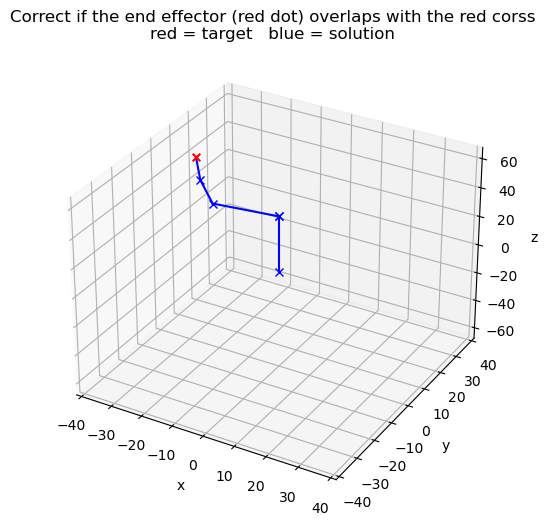

In [12]:
# Get the Position of end effector in frame 0
Pee = Matrix([0, 0, 0, 1])
P0e = T0e * Pee

ax = plt.figure(figsize=[8, 6]).add_subplot(projection='3d')

# target values (target position of end effector)
P0e_target = Matrix(T0e_target) * Pee
ax.scatter(P0e_target[0], P0e_target[1], P0e_target[2], s=30, c='r', marker='x')

# solutino values (position of end effector found from inverse kinematics equations)
solution_vals = {l0: l0_val, l2: l2_val, l3: l3_val, l4: l4_val, le: le_val, 
                 theta2: theta2_ans, theta3: theta3_ans, theta4: theta4_ans, 
                 d1: d1_ans}
end_pos = P0e.subs(solution_vals)
ax.scatter(end_pos[0], end_pos[1], end_pos[2], s=10, c='r', marker='.')

Pii_pos = Matrix([0, 0, 0, 1])
P01_pos = (T01 * Pii_pos).subs(solution_vals)
P02_pos = (T01 * T12 * Pii_pos).subs(solution_vals)
P03_pos = (T01 * T12 * T23 * Pii_pos).subs(solution_vals)
P04_pos = (T01 * T12 * T23 * T34 * Pii_pos).subs(solution_vals)

plot_links(ax, [Pii_pos, P01_pos, P02_pos, P03_pos, P04_pos, end_pos],
           show_coor=False)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
x_max = l2_val + l3_val + l4_val
z_max = 40 + l0_val + le_val
ax.set_xlim([-x_max*1, x_max*1])
ax.set_ylim([-x_max*1, x_max*1])
ax.set_zlim([-z_max*1, z_max*1])
ax.set_title("Correct if the end effector (red dot) overlaps with the red corss\nred = target   blue = solution")
plt.show()